In [13]:
pip install scikit-optimize


   ---------------------------------------- 2/2 [scikit-optimize]

Note: you may need to restart the kernel to use updated packages.


In [115]:
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import random
import numpy as np
import tensorflow as tf

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [116]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#### Load the three different datasets, add a new feature to specify which dataset each entry is from, and merge

In [117]:
train_df = pd.read_csv("train_features.csv").set_index("id")
cur_df = pd.read_csv("cur_features.csv").set_index("id")
full_df = pd.read_csv("full_features.csv").set_index("id")
test_df = pd.read_csv("test_features.csv").set_index("id")

In [118]:
train_df["Source"] = "Kag"
cur_df["Source"] = "Curated"
full_df["Source"] = "Full"
test_df["Source"] = "Kag"

train_df["priority"] = 0
cur_df["priority"] = 1
full_df["priority"] = 2

In [119]:
combined_df = pd.concat([train_df, cur_df, full_df], ignore_index = True)
combined_df = combined_df.sort_values(["SMILES", "priority"])
combined_df = combined_df.drop_duplicates(subset = "SMILES", keep = "first")
combined_df = combined_df.drop(columns = {"priority"})

In [120]:
print(combined_df["Source"].value_counts())
print(combined_df.shape)

Source
Full       12796
Kag         2662
Curated     1407
Name: count, dtype: int64
(16865, 2088)


In [121]:
combined_df.head(4)

,SMILES,Tm,MolWt,LogP,TPSA,HBD,HBA,RotB,RingCount,FracCSP3,...,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047,Source
8682,B(C)(O)O,92.0,59.861,-0.9110,40.46,2,2,0,0,1.000000,...,0,0,0,0,0,0,0,0,0,Full
8204,B(C1CC1)(O)O,93.0,85.899,-0.3768,40.46,2,2,1,1,1.000000,...,0,0,0,0,0,0,0,0,0,Full
7354,B(C=CCC(C)C)(O)O,101.0,127.980,0.6007,40.46,2,2,3,0,0.666667,...,0,0,0,0,0,0,0,0,0,Full
4175,B(C=CCCC)(O)O,80.0,113.953,0.3547,40.46,2,2,3,0,0.600000,...,0,0,0,0,0,0,0,0,0,Full


### Feature engineer class. Adds some additional engineered features from the Rdkit descriptors, drops very rare and very common FPs, and filters all features which are very highly correlated. Optional feature normalization and one-hot encoding

In [122]:
import numpy as np
import pandas as pd


class FeatureEngineer:
    
    def __init__(
        self, 
        corr_threshold: float = 1.00, 
        min_fp_freq: float = 0.00,
        max_fp_freq: float = 1.00,
        verbose: bool = True,
        normalize: bool = False,   # whether to normalise numeric features
        onehot_cats: bool = False, # whether to one-hot encode categoricals
        cat_cols: list | None = None,  # which categorical columns to one-hot (None = auto-detect)
    ):
        self.corr_threshold = corr_threshold
        self.min_fp_freq = min_fp_freq
        self.max_fp_freq = max_fp_freq
        self.verbose = verbose
        self.normalize = normalize
        self.onehot_cats = onehot_cats
        self.cat_cols = cat_cols

        # will be populated in fit()
        self.fp_drop_cols_ = []
        self.corr_drop_cols_ = []
        self.fitted_ = False

        # for normalisation
        self.norm_cols_ = None
        self.norm_means_ = None
        self.norm_stds_ = None

        # for one-hot encoding
        self.cat_cols_ = []         # original categorical columns used for OHE
        self.ohe_dummy_cols_ = []   # all dummy columns created
        self.feature_order_ = None  # final column order after all FE

        # for NaN filling (numeric cols)
        self.fill_values_ = None    # pandas Series of means (index = column names)

    # ---------- 0. Add engineered descriptor features ---------- #
    @staticmethod
    def _add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        eps = 1e-6  # avoid div-by-zero

        # H-bonding / polarity related
        df["HBD_HBA_sum"]   = df["HBD"] + df["HBA"]
        df["HBD_HBA_ratio"] = df["HBD"] / (df["HBA"] + eps)

        df["HBD_per_heavy"] = df["HBD"] / (df["HeavyAtomCount"] + eps)
        df["HBA_per_heavy"] = df["HBA"] / (df["HeavyAtomCount"] + eps)

        df["TPSA_per_MW"]     = df["TPSA"] / (df["MolWt"] + eps)
        df["TPSA_per_heavy"]  = df["TPSA"] / (df["HeavyAtomCount"] + eps)

        # Heteroatom & aromaticity fractions
        df["HetFrac"]          = df["NumHeteroatoms"] / (df["HeavyAtomCount"] + eps)
        df["AromaticFrac"]     = df["NumAromaticAtoms"] / (df["HeavyAtomCount"] + eps)
        df["AromaticRingFrac"] = df["NumAromaticRings"] / (df["RingCount"] + eps)
        df["RingDensity"]      = df["RingCount"] / (df["HeavyAtomCount"] + eps)

        # Packing / density-ish proxies
        df["MW_per_ASA"]     = df["MolWt"] / (df["LabuteASA"] + eps)
        df["Heavy_per_ASA"]  = df["HeavyAtomCount"] / (df["LabuteASA"] + eps)

        return df

    # ---------- 1. “GET” methods: compute columns to drop ---------- #
    def get_fp_drop_cols(self, df: pd.DataFrame):
        fp_cols = [c for c in df.columns if c.startswith("FP")]
        if not fp_cols:
            if self.verbose:
                print("No FP columns found for fingerprint frequency filter.")
            return []

        freq_fp = df[fp_cols].mean(axis=0)
        below_mask = freq_fp < self.min_fp_freq
        above_mask = freq_fp > self.max_fp_freq
        drop_fp_cols = freq_fp[below_mask | above_mask].index.tolist()

        if self.verbose:
            before = len(fp_cols)
            after = before - len(drop_fp_cols)
            print("Fingerprint frequency filter:")
            print(f" - threshold min={self.min_fp_freq}, max={self.max_fp_freq}")
            print(f" - would drop {len(drop_fp_cols)} FP columns")
            print(f" - remaining FP columns: {after}/{before}")

        return drop_fp_cols

    
    def get_corr_drop_cols(self, df: pd.DataFrame, target_col: str = "Tm"):
        # compute corr on numeric columns only
        corr = df.corr(numeric_only=True)

        # only features (exclude target from being dropped)
        feature_cols = [c for c in corr.columns if c != target_col]
        if len(feature_cols) < 2:
            if self.verbose:
                print("Not enough feature columns for correlation filtering.")
            return []

        corr_sub = corr.loc[feature_cols, feature_cols]

        mask = np.triu(np.ones(corr_sub.shape, dtype=bool), k=1)
        stacked = corr_sub.where(mask).stack()

        filtered = stacked[abs(stacked) > self.corr_threshold]
        if filtered.empty:
            if self.verbose:
                print(f"No redundant pairs found at threshold {self.corr_threshold}.")
            return []

        redundant_pairs_df = filtered.reset_index()
        redundant_pairs_df.columns = ["Item_1", "Item_2", "Item_1_Item_2_corr"]

        # add target correlations if available
        if target_col in corr.index:
            redundant_pairs_df["Item_1_target_cor"] = redundant_pairs_df["Item_1"].map(corr[target_col])
            redundant_pairs_df["Item_2_target_cor"] = redundant_pairs_df["Item_2"].map(corr[target_col])
        else:
            redundant_pairs_df["Item_1_target_cor"] = 0.0
            redundant_pairs_df["Item_2_target_cor"] = 0.0

        item_count = pd.concat(
            [redundant_pairs_df["Item_1"], redundant_pairs_df["Item_2"]],
            ignore_index=True
        ).value_counts()

        def choose_worse(row):
            i = row["Item_1"]
            j = row["Item_2"]

            # Rule A – appears in more redundant pairs
            if item_count[i] > item_count[j]:
                return i
            if item_count[j] > item_count[i]:
                return j

            # Rule B – less correlated with target
            if abs(row["Item_1_target_cor"]) < abs(row["Item_2_target_cor"]):
                return i
            else:
                return j

        redundant_pairs_df["drop"] = redundant_pairs_df.apply(choose_worse, axis=1)
        drop_cols = redundant_pairs_df["drop"].unique().tolist()

        if self.verbose:
            print(
                f"Correlation filter: would drop {len(drop_cols)} columns at threshold {self.corr_threshold}"
            )

        return drop_cols

    # ---------- 2. Apply drops to any dataframe ---------- #
    @staticmethod
    def drop_columns(df: pd.DataFrame, cols_to_drop) -> pd.DataFrame:
        return df.drop(columns=list(cols_to_drop), errors="ignore")

    # ---------- 3. High-level fit / transform ---------- #
    def fit(self, df: pd.DataFrame, target_col: str = "Tm"):
        """
        Decide which columns to drop based on TRAINING data only.
        Does NOT modify df in-place; just stores the lists.
        Also learns normalisation stats, NaN fill values, and one-hot encoding structure (if enabled).
        """
        # 0) add engineered features first
        df_eng = self._add_engineered_features(df)

        total_cols_init = df_eng.shape[1]

        # 1) frequency filters first (on engineered dataframe)
        fp_drop = self.get_fp_drop_cols(df_eng)
        df_tmp = self.drop_columns(df_eng, fp_drop)

        # 2) correlation filter on remaining features
        corr_drop = self.get_corr_drop_cols(df_tmp, target_col=target_col)

        self.fp_drop_cols_ = fp_drop
        self.corr_drop_cols_ = corr_drop
        self.fitted_ = True

        if self.verbose:
            total = len(set(fp_drop) | set(corr_drop))
            print(f"Total unique cols to drop after fit: {total}")
            print(f"Total cols remaining after drops: {(total_cols_init - total)}")

        # df after all drops (but BEFORE any one-hot) – used for norm, NaN fill, and ohe logic
        all_drops = set(fp_drop) | set(corr_drop)
        if "SMILES" in df_eng.columns:
            all_drops.add("SMILES")
        df_after_drop = self.drop_columns(df_eng, all_drops)

        # 3) Identify numeric columns with NaNs and compute fill values (means)
        self.fill_values_ = df_after_drop.mean(numeric_only=True)

        if self.verbose:
            na_cols = df_after_drop.columns[df_after_drop.isna().any()].tolist()
            print(f"{len(na_cols)} cols with NaNs after drop: {na_cols}")

        # For normalisation, it's cleaner to work on a filled copy
        df_for_norm = df_after_drop.copy()
        if self.fill_values_ is not None and not self.fill_values_.empty:
            intersect = [c for c in df_for_norm.columns if c in self.fill_values_.index]
            df_for_norm[intersect] = df_for_norm[intersect].fillna(self.fill_values_[intersect])

        # 4) compute normalisation stats on remaining numeric, non-FP features
        if self.normalize:
            num_cols = []
            for c in df_for_norm.columns:
                if c == target_col:
                    continue
                if c.startswith("FP"):
                    continue
                dtype = df_for_norm[c].dtype
                if dtype == "object" or str(dtype).startswith("category"):
                    continue
                num_cols.append(c)

            self.norm_cols_ = num_cols
            if num_cols:
                means = df_for_norm[num_cols].mean()
                stds = df_for_norm[num_cols].std().replace(0.0, 1.0)
                self.norm_means_ = means
                self.norm_stds_ = stds

                if self.verbose:
                    print(f"Normalisation enabled for {len(num_cols)} columns.")
            else:
                if self.verbose:
                    print("Normalisation enabled but no numeric columns found for scaling.")

        # 5) learn one-hot encoding structure (if enabled)
        if self.onehot_cats:
            # decide which categorical columns to encode
            if self.cat_cols is not None:
                cat_cols = [c for c in self.cat_cols if c in df_after_drop.columns]
            else:
                # auto-detect object/category cols (excluding target if present)
                cat_cols = [
                    c for c in df_after_drop.columns
                    if c != target_col
                    and (df_after_drop[c].dtype == "object"
                         or str(df_after_drop[c].dtype).startswith("category"))
                ]

            self.cat_cols_ = cat_cols

            if cat_cols:
                # one-hot on a copy so we can capture the full dummy column set
                df_ohe = pd.get_dummies(df_after_drop, columns=cat_cols, drop_first=False)

                # dummy columns are the new columns introduced
                original_cols = set(df_after_drop.columns)
                self.ohe_dummy_cols_ = [c for c in df_ohe.columns if c not in original_cols]

                # final feature order (without target if it’s still present)
                self.feature_order_ = [c for c in df_ohe.columns if c != target_col]

                if self.verbose:
                    print(f"One-hot encoding enabled for {len(cat_cols)} columns.")
                    print(f"Created {len(self.ohe_dummy_cols_)} dummy columns.")
            else:
                # no categoricals found
                self.ohe_dummy_cols_ = []
                # still set feature_order_ to the columns after drop
                self.feature_order_ = [c for c in df_after_drop.columns if c != target_col]
                if self.verbose:
                    print("One-hot encoding enabled but no categorical columns found.")
        else:
            # no one-hot encoding; keep order after drops
            self.cat_cols_ = []
            self.ohe_dummy_cols_ = []
            self.feature_order_ = [c for c in df_after_drop.columns if c != target_col]

        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply the learned feature engineering, drops, NaN filling,
        (optionally) normalisation and (optionally) one-hot encoding
        to ANY dataset (train/test/val).
        Output columns are always in the same order as learned in fit().
        """
        if not self.fitted_:
            raise RuntimeError("FeatureEngineer must be fitted before calling transform().")

        # 0) add engineered features
        df_eng = self._add_engineered_features(df)

        # 1) drop learned columns
        all_drops = set(self.fp_drop_cols_) | set(self.corr_drop_cols_)
        if "SMILES" in df_eng.columns:
            all_drops.add("SMILES")

        df_clean = self.drop_columns(df_eng, all_drops)

        # 2) fill NaNs using training means (for numeric columns we learned means for)
        if self.fill_values_ is not None and not self.fill_values_.empty:
            intersect = [c for c in df_clean.columns if c in self.fill_values_.index]
            if intersect:
                df_clean[intersect] = df_clean[intersect].fillna(self.fill_values_[intersect])

        # 3) apply normalisation if requested (only on norm_cols_)
        if self.normalize and self.norm_cols_ is not None and self.norm_means_ is not None:
            for c in self.norm_cols_:
                if c in df_clean.columns:
                    df_clean[c] = (df_clean[c] - self.norm_means_[c]) / self.norm_stds_[c]

        # 4) apply one-hot encoding if enabled
        if self.onehot_cats and self.cat_cols_:
            # important: same categorical columns as in fit
            df_ohe = pd.get_dummies(df_clean, columns=self.cat_cols_, drop_first=False)

            # ensure all dummy columns seen during fit exist now
            for col in self.ohe_dummy_cols_:
                if col not in df_ohe.columns:
                    df_ohe[col] = 0

            # final reordering: use feature_order_ (no target)
            df_ohe = df_ohe.reindex(columns=self.feature_order_, fill_value=0)
            return df_ohe

        else:
            # no OHE: just reorder to feature_order_ (if present)
            if self.feature_order_ is not None:
                df_clean = df_clean.reindex(columns=self.feature_order_, fill_value=0)
            return df_clean

In [123]:
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin

class CatBoostFEModel(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        # CatBoost params (tunable)
        depth: int = 3,
        learning_rate: float = 0.06,
        n_estimators: int = 1100,
        l2_leaf_reg: float = 2.5,
        bagging_temperature: float = 0.25,
        random_strength: int = 1,
        grow_policy: str = "SymmetricTree",
        rsm: float = 0.75,
        min_data_in_leaf: int = 1,
        leaf_estimation_iterations: int = 1,
        loss_function: str = "MAE",
        random_state: int = 42,
        cb_verbose: bool = False,

        # FeatureEngineer hyperparams (tunable)
        corr_threshold: float = 0.90,
        min_fp_freq: float = 0.01,
        max_fp_freq: float = 0.80,
        fe_verbose: bool = False,
        target_col: str = "Tm",
    ):
        # CatBoost params
        self.depth = depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.l2_leaf_reg = l2_leaf_reg
        self.bagging_temperature = bagging_temperature
        self.random_strength = random_strength
        self.grow_policy = grow_policy
        self.rsm = rsm
        self.min_data_in_leaf = min_data_in_leaf
        self.leaf_estimation_iterations = leaf_estimation_iterations
        self.loss_function = loss_function
        self.random_state = random_state
        self.cb_verbose = cb_verbose

        # FE params
        self.corr_threshold = corr_threshold
        self.min_fp_freq = min_fp_freq
        self.max_fp_freq = max_fp_freq
        self.fe_verbose = fe_verbose
        self.target_col = target_col

        # will be created in fit
        self.fe_ = None
        self.model_ = None
        self.cat_feature_indices_ = None

    def fit(self, X, y):
        """
        X: DataFrame with raw features (no Tm column)
        y: target Series/array (Tm values)
        """
        # 1. build training df with target for correlation-based FE
        df_with_target = X.copy()
        df_with_target[self.target_col] = y

        # 2. set up FeatureEngineer with current hyperparams
        self.fe_ = FeatureEngineer(
            corr_threshold=self.corr_threshold,
            min_fp_freq=self.min_fp_freq,
            max_fp_freq=self.max_fp_freq,
            verbose=self.fe_verbose,
            normalize = False
        )

        # 3. fit FE and transform training data
        self.fe_.fit(df_with_target, target_col=self.target_col)
        X_trans = self.fe_.transform(X)

        # ---- detect categorical columns (like "Source") ---- #
        cat_cols = [
            c for c in X_trans.columns
            if X_trans[c].dtype == "object"
            or str(X_trans[c].dtype).startswith("category")
        ]
        self.cat_feature_indices_ = [
            X_trans.columns.get_loc(c) for c in cat_cols
        ]

        if self.cb_verbose:
            print("Categorical columns:", cat_cols)
            print("Categorical feature indices:", self.cat_feature_indices_)

        # 4. build CatBoost params
        cb_params = dict(
            random_seed=self.random_state,
            loss_function=self.loss_function,
            depth=self.depth,
            learning_rate=self.learning_rate,
            min_data_in_leaf=self.min_data_in_leaf,
            leaf_estimation_iterations=self.leaf_estimation_iterations,
            n_estimators=self.n_estimators,
            l2_leaf_reg=self.l2_leaf_reg,
            random_strength=self.random_strength,
            bootstrap_type="Bayesian",
            bagging_temperature=self.bagging_temperature,
            grow_policy=self.grow_policy,
            rsm=self.rsm,
            verbose=self.cb_verbose,
        )

        # 5. train CatBoost, explicitly passing cat_features
        self.model_ = CatBoostRegressor(**cb_params)
        self.model_.fit(
            X_trans,
            y,
            cat_features=self.cat_feature_indices_,
            verbose=self.cb_verbose,
        )

        train_pred = self.model_.predict(X_trans)
        train_mae = mean_absolute_error(y, train_pred)
        #print(f"Training MAE: {train_mae:.4f}")

        return self

    def predict(self, X):
        """
        Apply the same feature engineering and CatBoost model to new data.
        """
        if self.fe_ is None or self.model_ is None:
            raise RuntimeError("Model is not fitted. Call fit(X, y) first.")

        X_trans = self.fe_.transform(X)
        # CatBoost already knows which features are categorical from training,
        # so we can just call predict:
        return self.model_.predict(X_trans)

In [124]:
from xgboost import XGBRegressor

class XGBModel(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        learning_rate: float = 0.07,
        n_estimators: int = 1000,
        max_depth: int = 6,
        min_child_weight: int = 2,
        subsample: float = 0.8,
        colsample_bytree: float = 0.8,
        reg_lambda: float = 1,
        reg_alpha: float = 0,
        gamma: float = 0,
        colsample_bylevel: float = 1.0,
        tree_method: str = "hist",
        max_bin: int = 256,
        objective: str = "reg:absoluteerror",
        eval_metric: str = "mae",
        random_seed: int = 42,
        xgb_verbose: bool = False,

        # FeatureEngineer hyperparams (tunable)
        corr_threshold: float = 0.90,
        min_fp_freq: float = 0.01,
        max_fp_freq: float = 0.80,
        fe_verbose: bool = False,
        target_col: str = "Tm",
    ):
        # XGB params
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.gamma = gamma
        self.colsample_bylevel = colsample_bylevel
        self.tree_method = tree_method
        self.max_bin = max_bin
        self.objective = objective
        self.eval_metric = eval_metric
        self.random_seed = random_seed
        self.xgb_verbose = xgb_verbose

        # FeatureEngineer params
        self.corr_threshold = corr_threshold
        self.min_fp_freq = min_fp_freq
        self.max_fp_freq = max_fp_freq
        self.fe_verbose = fe_verbose
        self.target_col = target_col

        # runtime attributes
        self.fe_ = None
        self.model_ = None
        self.cat_feature_indices_ = None

    def fit(self, X, y):
        # 1. build training df with target for correlation-based FE
        df_with_target = X.copy()
        df_with_target[self.target_col] = y

        # 2. FeatureEngineer
        self.fe_ = FeatureEngineer(
            corr_threshold=self.corr_threshold,
            min_fp_freq=self.min_fp_freq,
            max_fp_freq=self.max_fp_freq,
            verbose=self.fe_verbose,
            normalize=False,
        )

        self.fe_.fit(df_with_target, target_col=self.target_col)
        X_trans = self.fe_.transform(X)

        # detect categoricals
        cat_cols = [
            c for c in X_trans.columns
            if X_trans[c].dtype == "object"
            or str(X_trans[c].dtype).startswith("category")
        ]
        self.cat_feature_indices_ = [
            X_trans.columns.get_loc(c) for c in cat_cols
        ]

        if self.xgb_verbose:
            print("Categorical columns:", cat_cols)
            print("Categorical feature indices:", self.cat_feature_indices_)

        if cat_cols:
            X_trans[cat_cols] = X_trans[cat_cols].astype("category")

        xgb_params = dict(
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_child_weight=self.min_child_weight,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            colsample_bylevel=self.colsample_bylevel,
            reg_lambda=self.reg_lambda,
            reg_alpha=self.reg_alpha,
            gamma=self.gamma,
            tree_method=self.tree_method,
            max_bin=self.max_bin,
            objective=self.objective,
            eval_metric=self.eval_metric,
            random_state=self.random_seed,
            verbosity=int(self.xgb_verbose),
            n_jobs=-1,
            enable_categorical=True,
        )

        self.model_ = XGBRegressor(**xgb_params)
        self.model_.fit(X_trans, y)

        train_pred = self.model_.predict(X_trans)
        train_mae = mean_absolute_error(y, train_pred)
        if self.xgb_verbose:
            print(f"Training MAE: {train_mae:.4f}")

        return self

    def predict(self, X):
        if self.fe_ is None or self.model_ is None:
            raise RuntimeError("Model is not fitted. Call fit(X, y) first.")

        X_trans = self.fe_.transform(X)

        if self.cat_feature_indices_ is not None:
            cat_cols = [X_trans.columns[i] for i in self.cat_feature_indices_]
            if cat_cols:
                X_trans[cat_cols] = X_trans[cat_cols].astype("category")

        return self.model_.predict(X_trans)

In [125]:
from sklearn.neighbors import KNeighborsRegressor

class KNNModel(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        n_neighbors: int = 5,
        weights: str = "uniform",
        p: int = 2,
        algorithm: str = "auto",
        leaf_size: int = 30,
        n_jobs: int = -1,
        random_seed: int = 42,
        knn_verbose: bool = False,

        # FeatureEngineer hyperparams (tunable)
        corr_threshold: float = 0.90,
        min_fp_freq: float = 0.01,
        max_fp_freq: float = 0.80,
        fe_verbose: bool = False,
        target_col: str = "Tm",
    ):

        # --- KNN hyperparams ---
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.n_jobs = n_jobs
        self.random_seed = random_seed
        self.knn_verbose = knn_verbose

        # --- FeatureEngineer hyperparams ---
        self.corr_threshold = corr_threshold
        self.min_fp_freq = min_fp_freq
        self.max_fp_freq = max_fp_freq
        self.fe_verbose = fe_verbose
        self.target_col = target_col


    def fit(self, X, y):
        """
        X: DataFrame with raw features (no Tm column)
        y: target Series/array (Tm values)
        """
        # 1. build training df with target for correlation-based FE
        df_with_target = X.copy()
        df_with_target[self.target_col] = y
    
        # 2. FeatureEngineer with normalization enabled for KNN
        self.fe_ = FeatureEngineer(
            corr_threshold=self.corr_threshold,
            min_fp_freq=self.min_fp_freq,
            max_fp_freq=self.max_fp_freq,
            verbose=self.fe_verbose,
            normalize=True,
            onehot_cats=True, 
            cat_cols=["Source"],
        )
    
        # 3. fit FE and transform training data
        self.fe_.fit(df_with_target, target_col=self.target_col)
        X_trans = self.fe_.transform(X)
    
        if self.knn_verbose:
            print("KNN: transformed feature shape:", X_trans.shape)
            print("KNN: dtypes after FE:", X_trans.dtypes.value_counts())
    
      
        '''
        # 3a. drop any non-numeric (safety, e.g. if Source is still there)
        non_numeric = X_trans.select_dtypes(exclude=["number", "bool"]).columns
        if len(non_numeric) > 0 and self.knn_verbose:
            print("Dropping non-numeric columns for KNN during fit:", non_numeric.tolist())
        X_trans = X_trans.drop(columns=non_numeric)
    
        # 4. NaN diagnostics + imputation
        na_counts = X_trans.isna().sum()
        if na_counts.any() and self.knn_verbose:
            print("NaNs detected in KNN input during fit:")
            print(na_counts[na_counts > 0].sort_values(ascending=False).head(30))
            print("Imputing NaNs with column means (then 0 as fallback).")
    
        col_means = X_trans.mean(numeric_only=True)
        X_trans = X_trans.fillna(col_means)
        X_trans = X_trans.fillna(0.0)
        '''
    
        # 5. store feature names used for training
        self.feature_names_ = X_trans.columns.tolist()
    
        # 6. build and fit KNN model
        self.model_ = KNeighborsRegressor(
            n_neighbors=self.n_neighbors,
            weights=self.weights,
            p=self.p,
            algorithm=self.algorithm,
            leaf_size=self.leaf_size,
            n_jobs=self.n_jobs,
        )
    
        self.model_.fit(X_trans, y)
    
        # 7. training MAE for sanity check
        train_pred = self.model_.predict(X_trans)
        train_mae = mean_absolute_error(y, train_pred)
        if self.knn_verbose:
            print(f"KNN Training MAE: {train_mae:.4f}")
    
        return self

    def predict(self, X):
        """
        Apply the same feature engineering and KNN model to new data.
        """
        if self.fe_ is None or self.model_ is None:
            raise RuntimeError("Model is not fitted. Call fit(X, y) first.")
    
        # 1. transform with FE
        X_trans = self.fe_.transform(X)

        """
        # 2. drop non-numeric, same as in fit
        non_numeric = X_trans.select_dtypes(exclude=["number", "bool"]).columns
        if len(non_numeric) > 0 and self.knn_verbose:
            print("Dropping non-numeric columns for KNN during predict:", non_numeric.tolist())
        X_trans = X_trans.drop(columns=non_numeric)
    
        # 3. NaN handling, same as in fit
        col_means = X_trans.mean(numeric_only=True)
        X_trans = X_trans.fillna(col_means)
        X_trans = X_trans.fillna(0.0)
        
    
        # 4. align columns to those used during fit
        if hasattr(self, "feature_names_") and self.feature_names_ is not None:
            # drop unexpected cols and add missing ones as 0
            X_trans = X_trans.reindex(columns=self.feature_names_, fill_value=0.0)
        """
    
        return self.model_.predict(X_trans)

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
tf.random.set_seed(42)


class NNModel:
    def __init__(
        self,
        # FeatureEngineer hyperparams (tunable)
        corr_threshold: float = 0.90,
        min_fp_freq: float = 0.01,
        max_fp_freq: float = 0.90,
        fe_verbose: bool = False,
        target_col: str = "Tm",
    ):
        # --- FeatureEngineer hyperparams ---
        self.corr_threshold = corr_threshold
        self.min_fp_freq = min_fp_freq
        self.max_fp_freq = max_fp_freq
        self.fe_verbose = fe_verbose
        self.target_col = target_col

        # regularisation
        self.l2_reg = regularizers.l2(2e-5)

        # will be set in fit
        self.fe_ = None
        self.model_ = None
        self.feature_names_ = None
        self.history_ = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # ----------------- 0. SEEDS ----------------- #
        random.seed(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
    
        # ----------------- 1. HANDLE OPTIONAL VAL SPLIT ----------------- #
        if X_val is None or y_val is None:
            X_train, X_val, y_train, y_val = train_test_split(
                X_train,
                y_train,
                test_size=0.2,
                random_state=42,  # or 42, but nice to keep consistent
            )
    
        # ----------------- 2. FEATURE ENGINEERING ----------------- #
        # FeatureEngineer with normalization enabled for NN
        self.fe_ = FeatureEngineer(
            corr_threshold=self.corr_threshold,
            min_fp_freq=self.min_fp_freq,
            max_fp_freq=self.max_fp_freq,
            verbose=self.fe_verbose,
            normalize=True,
            onehot_cats=True,
            cat_cols=["Source"],
        )
    
        # fit FE and transform training / validation data
        self.fe_.fit(X_train, target_col=self.target_col)
        X_trans = self.fe_.transform(X_train)
        X_trans_val = self.fe_.transform(X_val)
    
        # cast to float32 for TF
        X_trans = X_trans.astype("float32")
        X_trans_val = X_trans_val.astype("float32")
        y_train = np.asarray(y_train, dtype="float32")
        y_val = np.asarray(y_val, dtype="float32")
    
        # store feature names used for training
        self.feature_names_ = X_trans.columns.tolist()
    
        # ----------------- 3. BUILD MODEL ----------------- #
        self.model_ = Sequential([
            Dense(512, activation="relu", kernel_regularizer=self.l2_reg),
            BatchNormalization(),
            Dropout(0.1),
    
            Dense(256, activation="relu", kernel_regularizer=self.l2_reg),
            BatchNormalization(),
            Dropout(0.1),
    
            Dense(256, activation="relu", kernel_regularizer=self.l2_reg),
            BatchNormalization(),
    
            Dense(1),  # output layer for regression
        ])
    
        self.model_.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mae",
            metrics=["mae"],
        )
    
        # ----------------- 4. CALLBACKS ----------------- #
        early_stop = EarlyStopping(
            monitor="val_mae",
            patience=30,
            restore_best_weights=True,
            verbose=0,
        )
    
        lr_reduce = ReduceLROnPlateau(
            monitor="val_mae",
            factor=0.8,
            patience=10,
            min_lr=1e-5,
            verbose=0,
        )
    
        # ----------------- 5. TRAIN ----------------- #
        self.history_ = self.model_.fit(
            X_trans,
            y_train,
            validation_data=(X_trans_val, y_val),
            epochs=500,
            batch_size=64,
            callbacks=[early_stop, lr_reduce],
            verbose=0,
            shuffle=True,  
        )
    
        return self

    def predict(self, X):
        if self.fe_ is None or self.model_ is None:
            raise RuntimeError("Model is not fitted. Call fit(...) first.")

        # 1. transform with FE
        X_trans = self.fe_.transform(X)
        X_trans = X_trans.astype("float32")

        # 2. predict and flatten to 1D array
        return self.model_.predict(X_trans).reshape(-1)

In [127]:
X = combined_df.drop(columns = {"Tm"})
y = combined_df["Tm"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [128]:
knn_fe_params = {
    "corr_threshold": 0.50,
    "min_fp_freq": 0.18,
    "max_fp_freq": 0.20,
}

knn_params = {
    "n_neighbors": 8,
    "weights": "distance",
    "p": 1,
    "algorithm": "auto",
    "leaf_size": 20,
}

xgb_fe_params = {
    "corr_threshold": 0.90,
    "min_fp_freq": 0.01,
    "max_fp_freq": 0.80,
}

xgb_params = {
    "max_depth": 8,
    "n_estimators": 1400,
    "learning_rate": 0.05,
    "min_child_weight": 5,
    "subsample": 0.7,
    "colsample_bytree": 1.0,
    "colsample_bylevel": 0.7,
    "reg_lambda": 2.0,
    "reg_alpha": 0.1,
    "gamma": 0.2,
}

cb_fe_params = {
    "corr_threshold": 0.90,
    "min_fp_freq": 0.01,
    "max_fp_freq": 0.80,
}

cb_params = {
    "depth": 8,
    "n_estimators": 1600,
    "l2_leaf_reg": 18,
    "learning_rate": 0.075,
    "bagging_temperature": 0.30,
    "random_strength": 0.75,
    "grow_policy": "SymmetricTree",
    "rsm": 0.45,
    "min_data_in_leaf": 18,
    "leaf_estimation_iterations": 5,
    "loss_function": "MAE",
}

nn_fe_params = {
    "corr_threshold": 0.95,
    "min_fp_freq": 0.001,
    "max_fp_freq": 0.999,
}
    
best_cat_model = CatBoostFEModel(**cb_params, **cb_fe_params)
best_xgb_model = XGBModel(**xgb_params, **xgb_fe_params)
best_knn_model = KNNModel(**knn_params, **knn_fe_params)
best_nn_model = NNModel(**nn_fe_params)

base_models = {
    "best_cat_model": best_cat_model,
    "best_xgb_model": best_xgb_model,
    "best_knn_model": best_knn_model,
    "best_nn_model": best_nn_model,
}

In [42]:
best_cat_model.fit(X_train, y_train)
best_xgb_model.fit(X_train, y_train)
best_knn_model.fit(X_train, y_train)
best_nn_model.fit(X_train, y_train)


Epoch 51: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 107: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 117: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
Epoch 117: early stopping
Restoring model weights from the end of the best epoch: 87.


In [43]:
y_cat = best_cat_model.predict(X_val)
y_xgb = best_xgb_model.predict(X_val)
y_knn = best_knn_model.predict(X_val)
y_nn = best_nn_model.predict(X_val)

print(f" CatBoost MAE: {mean_absolute_error(y_cat, y_val)}")
print(f" XGB MAE: {mean_absolute_error(y_xgb, y_val)}")
print(f" KNN MAE: {mean_absolute_error(y_knn, y_val)}")
print(f" NN MAE: {mean_absolute_error(y_nn, y_val)}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 CatBoost MAE: 25.74567849456645
 XGB MAE: 26.111841918149125
 KNN MAE: 36.22784764527904
 NN MAE: 26.620024754569187


In [129]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import copy

model_names = list(base_models.keys())
n_models = len(model_names)

# full training data
X_train_full = train_df.drop(columns=["Tm"])
y_train_full = train_df["Tm"].values

n_samples = X_train_full.shape[0]

# OOF prediction matrix
X_meta = np.zeros((n_samples, n_models), dtype=float)
y_meta = y_train_full.copy()  # same targets

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_full)):
    print(f"\n=== Fold {fold+1}/5 ===")
    X_tr, X_val = X_train_full.iloc[tr_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full[tr_idx], y_train_full[val_idx]

    for j, (name, template_model) in enumerate(base_models.items()):
        print(f"  Training base model '{name}' on fold {fold+1}...")
        # deep copy to keep hyperparams but reset fit state
        model = copy.deepcopy(template_model)
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)

        X_meta[val_idx, j] = y_val_pred

        fold_mae = mean_absolute_error(y_val, y_val_pred)
        print(f"    {name} fold MAE: {fold_mae:.3f}")

print("X_meta shape:", X_meta.shape)  # (n_samples, n_models)

# ----------------- 3. FIT RIDGE STACKER ON META-DATA ----------------- #

ridge = Ridge(alpha=1.0)
ridge.fit(X_meta, y_meta)

# ----------------- 4. REFIT BASE MODELS ON FULL TRAINING DATA -------- #

fitted_base_models = {}
for name, template_model in base_models.items():
    print(f"\nFitting {name} on full training data...")
    model = copy.deepcopy(template_model)
    model.fit(X_train_full, y_train_full)
    fitted_base_models[name] = model


=== Fold 1/5 ===
  Training base model 'best_cat_model' on fold 1...
    best_cat_model fold MAE: 29.315
  Training base model 'best_xgb_model' on fold 1...
    best_xgb_model fold MAE: 29.632
  Training base model 'best_knn_model' on fold 1...
    best_knn_model fold MAE: 37.342
  Training base model 'best_nn_model' on fold 1...
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
    best_nn_model fold MAE: 31.527

=== Fold 2/5 ===
  Training base model 'best_cat_model' on fold 2...
    best_cat_model fold MAE: 28.226
  Training base model 'best_xgb_model' on fold 2...
    best_xgb_model fold MAE: 28.585
  Training base model 'best_knn_model' on fold 2...
    best_knn_model fold MAE: 37.764
  Training base model 'best_nn_model' on fold 2...
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
    best_nn_model fold MAE: 30.464

=== Fold 3/5 ===
  Training base model 'best_cat_model' on fold 3...
    best_cat_model fold MAE: 29.060
  Training base model 'best_xgb_model' on fold 3...
    best_xgb_model fold MA

In [130]:
# ----------------- 5. BUILD META-FEATURES FOR TEST ------------------- #

X_test = test_df  # Kaggle test, no Tm

N_test = X_test.shape[0]
test_meta_features = np.zeros((N_test, n_models), dtype=float)

for j, (name, model) in enumerate(fitted_base_models.items()):
    test_meta_features[:, j] = model.predict(X_test)

# ----------------- 6. STACKED PREDICTIONS FOR TEST ------------------- #

y_test_ens = ridge.predict(test_meta_features)

# e.g. build submission
sub = pd.DataFrame({
    "id": test_df.index,  
    "Tm": y_test_ens,
})

sub = sub.set_index("id")
sub.to_csv("submission_stacked_ridge.csv", index=True)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [111]:
sub

,Tm
id,
2,386.279463
4,324.856241
9,512.100565
18,659.891731
19,235.741228
...,...
3312,331.169472
3313,350.342216
3314,408.264941


In [112]:
print("Intercept:", ridge.intercept_)
print("Coefs:", dict(zip(model_names, ridge.coef_)))

Intercept: -3.109366193548169
Coefs: {'best_cat_model': np.float64(0.27643706631411186), 'best_xgb_model': np.float64(0.5935871975098954), 'best_knn_model': np.float64(-0.01732792633287298), 'best_nn_model': np.float64(0.1689990040558685)}


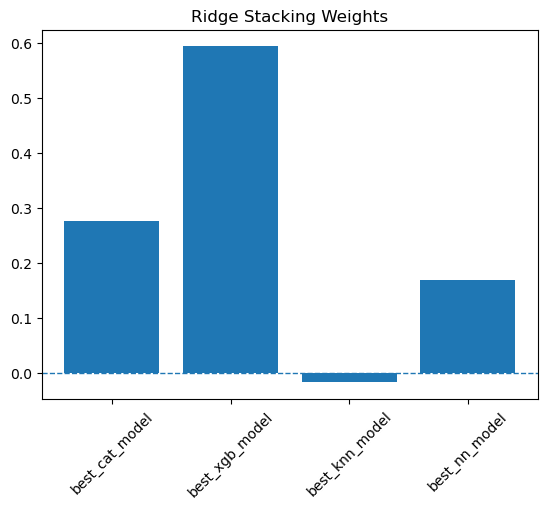

In [113]:
import matplotlib.pyplot as plt

weights = ridge.coef_
plt.bar(model_names, weights)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xticks(rotation=45)
plt.title("Ridge Stacking Weights")
plt.show()